In [3]:
import psycopg
from psycopg import sql
import importlib
import config
importlib.reload(config)
import pandas as pd
from typing import List, Dict, Any, Mapping, Tuple
from datetime import datetime
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

In [4]:
with open('/home/pjtl2w01admin/csm/VizTool_pjt/network_graph/graph_json.json', 'r') as f:
    graph_json = json.load(f)

### 계층 및 그래프 구성

#### 1. 계층 구조 조성 (Group > Attr > Node)

In [5]:
def build_filter_hierarchy(graph_data):
    hierarchy = defaultdict(lambda: defaultdict(lambda: defaultdict(set)))

    for node in graph_data['nodes']:
        group = node['data']['parent']  #group
        label = node['data']['label']   #node

        for attr, value in node['data'].items(): #attributes
            if attr not in ['parent', 'label']:
                hierarchy[group][attr][value].add(label)
    
    return hierarchy

In [6]:
hierarchy = build_filter_hierarchy(graph_json)
print(json.dumps(hierarchy, indent=2, default=list))

{
  "C": {
    "doc_no": {
      "0000000001": [
        "Sales Order 1"
      ],
      "0000000002": [
        "Sales Order 2"
      ],
      "0000000003": [
        "Sales Order 3"
      ],
      "0000000004": [
        "Sales Order 4"
      ],
      "0000000005": [
        "Sales Order 5"
      ]
    },
    "item": {
      "10": [
        "Sales Order 5",
        "Sales Order 3",
        "Sales Order 1",
        "Sales Order 4"
      ],
      "20": [
        "Sales Order 2"
      ]
    },
    "material": {
      "FERT001": [
        "Sales Order 1"
      ],
      "FERT002": [
        "Sales Order 2"
      ],
      "FERT003": [
        "Sales Order 3"
      ],
      "COMP001": [
        "Sales Order 4"
      ],
      "FERT005": [
        "Sales Order 5"
      ]
    },
    "description": {
      "GRANDEUR": [
        "Sales Order 1"
      ],
      "SONATA": [
        "Sales Order 2"
      ],
      "IONIQ": [
        "Sales Order 3"
      ],
      "BATTERY PACK": [
        "Sales Order

#### 2. 역색인 생성

In [7]:
def build_reverse_index(hierarchy):
    index = defaultdict(set)
    attr_to_groups = defaultdict(set)

    for group, group_data in hierarchy.items():
        for attr, attr_data in group_data.items():
            all_nodes = {n for nodes in attr_data.values() for n in nodes}
            # <결과: 노드>
            # 1. 그룹 단위
            index[(group,)].update(all_nodes)

            # 2. 그룹 + 속성 단위
            index[(group, attr)].update(all_nodes)

            # 3. 속성 단위
            index[(attr,)].update(all_nodes)

            # <결과: 그룹>
            # 4. 속성 단위
            attr_to_groups[attr].add(group)
        
    return index, attr_to_groups

역색인 저장 / 로드

In [8]:
#메인 함수에서...
# reversed_index = build_reverse_index 먼저 선행

In [9]:
def save_index(index, path='./reverse_index.pkl'):
    with open(path, 'wb') as f:
        pickle.dump(index, f)

In [10]:
def load_index(path='./reverse_index.pkl'):
    with open(path, 'rb') as f:
        return pickle.load(f)

#### 3. 네트워크 데이터로 변환

In [11]:
nodes = graph_json['nodes']
edges = graph_json['edges']

print(len(nodes), "nodes loaded")
print(len(edges), "edges loaded")

25 nodes loaded
20 edges loaded


In [12]:
nodes_df = pd.DataFrame(nodes)
nodes_df

,id,data
0,C-10,"{'parent': 'C', 'label': 'Sales Order 1', 'doc..."
1,J-10,"{'parent': 'J', 'label': 'Outbound Delivery 1'..."
2,R-10,"{'parent': 'R', 'label': 'Goods Issue 1', 'doc..."
3,M-10,"{'parent': 'M', 'label': 'Invoice 1', 'doc_no'..."
4,E-10,"{'parent': 'E', 'label': 'Journal Entry 1', 'd..."
5,C-20,"{'parent': 'C', 'label': 'Sales Order 2', 'doc..."
6,J-20,"{'parent': 'J', 'label': 'Outbound Delivery 2'..."
7,R-20,"{'parent': 'R', 'label': 'Goods Issue 2', 'doc..."
8,M-20,"{'parent': 'M', 'label': 'Invoice 2', 'doc_no'..."
9,E-20,"{'parent': 'E', 'label': 'Journal Entry 2', 'd..."


In [13]:
edges_df = pd.DataFrame(edges)
edges_df

,source,target,id,data
0,C-10,J-10,C10_J10,{'label': 'Delivery Creation'}
1,J-10,R-10,J10_R10,{'label': 'Post Goods Issue'}
2,R-10,M-10,R10_M10,{'label': 'Billing'}
3,M-10,E-10,M10_E10,{'label': 'Accounting Posting'}
4,C-20,J-20,C20_J20,{'label': 'Delivery Creation'}
5,J-20,R-20,J20_R20,{'label': 'Post Goods Issue'}
6,R-20,M-20,R20_M20,{'label': 'Billing'}
7,M-20,E-20,M20_E20,{'label': 'Accounting Posting'}
8,C-30,J-30,C30_J30,{'label': 'Delivery Creation'}
9,J-30,R-30,J30_R30,{'label': 'Post Goods Issue'}


In [14]:
#방향 그래프 구성
G = nx.DiGraph()

#노드 추가
for _, row in nodes_df.iterrows():
    attrs = row['data'].copy()
    G.add_node(row['id'], **attrs)

#엣지 추가
for _, row in edges_df.iterrows():
    G.add_edge(row['source'], row['target'], label=row.get('id'))

In [15]:
print('총 노드 수:', G.number_of_nodes())
print('총 엣지 수:', G.number_of_edges())

총 노드 수: 25
총 엣지 수: 20


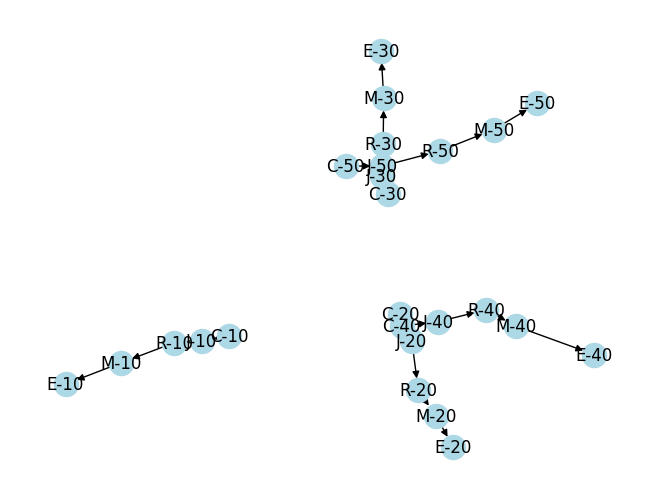

In [16]:
# 그래프 그리기
nx.draw(G, with_labels=True, node_color='lightblue')
plt.show()

그래프 빌드

In [17]:
# 위 내용 함수화 
def build_graph(nodes, edges):
    """노드/엣지 리스트를 받아 Networkx DiGraph 생성"""
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node['id'], **node.get('attributes', {}))
    for edge in edges:
        G.add_edge(edge['source'], edge['target'], **edge)
    return G

그래프 그리기

In [18]:
def draw_graph(G):
    nx.draw(G, with_labels=True, node_color='lightblue')
    plt.show()

서브 그래프 만들기

In [19]:
def build_subgraph(G, node_ids):
    """특정 노드들만 포함하는 서브그래프 반환"""
    #필터링된 노드들만 포함된 부분 그래프를 만들고 싶다면 node_ids = filtered['id'].tolist()를 선행
    subG = G.subgraph(node_ids).copy()
    return subG

----

### 종속 필터링

1. 그룹 리스트

In [20]:
def list_groups(hierarchy):
    return sorted(list(hierarchy.keys()))

2. 속성 리스트

In [21]:
def list_attributes(hieararchy, groups=None):
    if not groups:
        return sorted(
            set(attr for group, group_attr in hieararchy.items() for attr in group_attr.keys())
        )
    
    attributes = set()
    for g in groups:
        group_attr = hieararchy.get(g, {})
        attributes.update(group_attr.keys())
        
    return sorted(attributes)

3. Value 리스트

In [22]:
def list_values(hierarchy, groups=None, attributes=None):
    values = set()

    # 그룹이 선택되지 않은 경우
    if not groups:
        if not attributes: 
            for g_data in hierarchy.values():
                for attr_data in g_data.values(): #중복 A
                    values.update(str(key) for key in attr_data.keys()) 
            return sorted(values)

        for g_data in hierarchy.values():
            for attr in attributes:
                if attr in g_data:
                    attr_data = g_data[attr]
                    values.update(str(key) for key in attr_data.keys())
        return sorted(values)
    
    #그룹만 지정되어 있는 경우
    if not attributes:
        for g in groups:
            group_data = hierarchy.get(g, {})
            for attr_data in group_data.values(): #중복 A
                values.update(str(key) for key in attr_data.keys())
        return sorted(values)
        
    
    #그룹과 속성 모두 지정된 경우
    for g in groups:
        group_data = hierarchy.get(g, {})
        for attr in attributes:
            attr_data = group_data.get(attr, {})  #증복 A
            values.update(str(key) for key in attr_data.keys())
    
    return sorted(values)

기타 : Operator

In [23]:
def _run_operation(attr_value, target_value, operator):
    if operator in ("equal", "=", None):
        return str(attr_value) == str(target_value)
    if operator in ("greater", ">"):
        try:
            return float(attr_value) > float(target_value)
        except ValueError:
            return False
    if operator in ("lower", "<"):
        try:
            return float(attr_value) < float(target_value)
        except ValueError:
            return False
    if operator in ("contains", "in"):
        return str(target_value) in str(attr_value)
    return False

4. 노드 리스트

In [24]:
# 아무런 상위 항목이 정해지지 않은 경우
def list_all_nodes(graph_json):
    return sorted([n["data"]["label"] for n in graph_json.get("nodes", [])])

In [25]:
# 0. 주어진 그룹 집합을 대상으로 attr+value 조건을 만족하는 노드 반환 (그룹은 전체 그룹일수도 있음)
def _nodes_for_attr_value_over_groups(hierarchy, groups, attr, val, op) -> set:
    result = set()

    for g in groups:
        group_data = hierarchy.get(g, {})
        attr_data = group_data.get(attr, {})

        for attr_val, nodes in attr_data.items():
            if _run_operation(attr_val, val, op):
                result.update(nodes)
    
    return result

In [26]:
# 1. 그룹만 지정 -> 그룹 내 노드 반환
def _filter_nodes_for_groups(index, groups):
    result = set()

    for g in groups:
        result.update(index.get((g,), set()))

    return sorted(result)

In [27]:
# 2-1. 그룹x,속성o,값x 지정 -> 역색인 사용
def _nodes_for_attr_name_only(index, attr):
    """그룹 정보 없이 '속성명만' 주어진 경우: (attr,) 역색인 사용"""
    return index.get((attr,), set())

In [ ]:
# 2-2. 그룹x, 속성+값o 지정 -> hierarchy 탐색
def _nodes_for_attr_with_value(hierarchy, attr_to_groups_index, attr, val, op) -> set:
    """그룹 정보 없이 '속성+값'만 주어진 경우 : hierarchy 사용"""
    target_groups = attr_to_groups_index.get(attr, hierarchy.keys())

    return _nodes_for_attr_value_over_groups(hierarchy, target_groups, attr, val, op)

In [29]:
# 2. 속성만 있는 경우
def _filter_nodes_for_attr_only(hierarchy, index, attr_to_groups_index, attributes):
    if not attributes:
        return set()
    
    result = []

    for cond in attributes:
        attr = cond.get("attribute")
        val = cond.get("value")
        op = cond.get("operator")

        # 속성의 값이 지정되어있지 않은 경우
        if val is None or val=="":
            nodes = _nodes_for_attr_name_only(index, attr)
        # 속성과 값이 지정되어 있는 경우
        else:
            nodes = _nodes_for_attr_with_value(hierarchy, attr_to_groups_index, attr, val, op)
        
        result.append(nodes)
    
    return set.intersection(*result) if result else set() # 속성이 여러개일 경우 AND로 처리

In [30]:
# 3-1. 그룹, 속성명만 있는 경우
def _nodes_for_group_attr_name_only(index, group, attr):
    """특정 group 안에서 '속성명만' 주어진 경우: (group, attr) 역색인 사용"""
    return index.get((group, attr), set())

In [31]:
# 3-2. 그룹, 속성, 값 모두 있는 경우
def _nodes_for_group_attr_with_value(hierarchy, group, attr, val, op):
    """특정 group 안에서 '속성 + 값' 조건 하나를 처리: hierarchy[group][attr]에서 값 비교 후 매칭 노드 반환"""
    return _nodes_for_attr_value_over_groups(hierarchy, [group], attr, val, op)

In [ ]:
# 3-3. 한 그룹에서 여러 속성 조건 AND
def _nodes_for_group_with_conditions(hierarchy, index, group, attributes):
    """한 그룹에서 여러 attributes 조건을 모두 만족하는 노드 집합(AND)"""
    if not attributes:
        return set()
    
    result = []

    for cond in attributes:
        attr = cond.get("attribute")
        val = cond.get("value")
        op = cond.get("operator")
        
        # 속성의 값이 지정되어있지 않은 경우
        if val is None or val=="":
            nodes = _nodes_for_group_attr_name_only(index, group, attr)
        # 속성과 값이 지정되어 있는 경우
        else:
            nodes = _nodes_for_group_attr_with_value(hierarchy, group, attr, val, op)
        
        result.append(nodes)
    
    return set.intersection(*result) if result else set()

In [33]:
# 3. 그룹 + 속성 모두 지정된 경우
def _filter_by_groups_and_attributes(hierarchy, index, groups, attributes):
    result = set()

    for g in groups:
        nodes = _nodes_for_group_with_conditions(hierarchy, index, g, attributes)
        result.update(nodes) #그룹끼리는 OR (합집합)
        
    return result

In [ ]:
def filter_nodes(hierarchy, index, attr_to_groups_index, groups=None, attributes=None):
    result = set()
    groups = groups or []
    attributes = attributes or []
    attrs_with_groups = [cond for cond in attributes if cond.get("group")]
    attrs_without_groups = [cond for cond in attributes if not cond.get("group")]

    # 1. 그룹만 지정된 경우 : 역색인 사용
    if groups and not attributes:
        return sorted(_filter_nodes_for_groups(index, groups))
    
    # 2. 속성만 지정된 경우 : 역색인 사용
    if (not groups) and attrs_without_groups and not attrs_with_groups:
        return sorted(_filter_nodes_for_attr_only(hierarchy, index, attr_to_groups_index, attrs_without_groups))

    # 3. 그룹 + 속성 조합
    group_to_conds = defaultdict(list) #그룹별로 적용할 조건들을 모아두는 맵 - group_to_conds[g] = [그룹 g에 적용할 모든 조건들]
    
    ## attribute에 group이 지정된 경우
    for cond in attrs_with_groups:
        g = cond.get("group")
        c = {k: v for k, v in cond.items() if k != 'group'} #내부 로직에서는 group 키 필요 x - 제거
        group_to_conds[g].append(c)
    
    ## attribute에 group이 없는 경우
    for cond in attrs_without_groups:
        attr = cond.get("attribute")
        
        candidate_groups = set(attr_to_groups_index) # 이 attr을 실제로 가진 그룹 후보들

        if groups:  
            candidate_groups &= set(groups)  # selected.groups가 있으면 그 안에서만 적용

        for g in candidate_groups: 
            group_to_conds[g].append(cond)  # 각 그룹에 이 조건을 추가
    
    result = set()

    ## 그룹별로 조건 AND, 그룹끼리는 OR
    for g, conds_for_group in group_to_conds.items():
        if not conds_for_group:
            continue

        nodes = _nodes_for_group_with_conditions(hierarchy, index, g, conds_for_group)
        result.update(nodes)
    

    return sorted(result)

5. 메인 분기 함수

In [35]:
hierarchy = build_filter_hierarchy(graph_json)
index, attr_to_groups_index = build_reverse_index(hierarchy)

In [36]:
# 메인 분기 함수
def get_options(level, selected, graph_json, hierarchy, reversed_index, attr_to_groups_index):
    groups = selected.get("groups", [])
    nodes = selected.get("nodes", [])
    attributes = selected.get("attributes", [])

    match level:
        case "group":
            return list_groups(hierarchy)
        case "attribute":
            return list_attributes(hierarchy, groups)
        case "value":
            attrs = [attr['attribute'] for attr in attributes]
            return list_values(hierarchy, groups, attrs)
        case "node":
            if not groups and not attributes:
                return list_all_nodes(graph_json)
            return filter_nodes(hierarchy, reversed_index, attr_to_groups_index, groups, attributes)
        case _:
            raise ValueError(f"없는 레벨입니다: {level}")

In [48]:
def filter_dropdown_data(graph_json, level, selected):
    hierarchy = build_filter_hierarchy(graph_json)
    print("그룹 목록:", list(hierarchy.keys()))
    for g, g_data in hierarchy.items():
        print(f"\n[{g}] 속성 목록:", list(g_data.keys()))
        
    reversed_index, attr_to_groups_index = build_reverse_index(hierarchy)

    result = get_options(level, selected, graph_json, hierarchy, reversed_index, attr_to_groups_index)

    return result

In [50]:
level = "node"
selected = {
    "groups": ['C', 'R', 'M', 'E'],
    "attributes": [
        {"attribute": "value", "operator": "lower", "value" : "300000000"},
        {"attribute": "material", "operator": "equal", "value" : "FERT003"}
    ]
}
filter_dropdown_data(graph_json, level, selected)

그룹 목록: ['C', 'J', 'R', 'M', 'E']

[C] 속성 목록: ['doc_no', 'item', 'material', 'description', 'status', 'value', 'time', 'customer', 'region']

[J] 속성 목록: ['doc_no', 'item', 'material', 'status', 'time']

[R] 속성 목록: ['doc_no', 'item', 'material', 'status', 'value', 'time']

[M] 속성 목록: ['doc_no', 'item', 'material', 'status', 'value', 'time']

[E] 속성 목록: ['doc_no', 'item', 'material', 'status', 'value', 'time']


[]

----

### 경로 탐색

#### Node Exploration

#### Path Search